In [2]:
import mrcfile
import random
import numpy as np

from sklearn.neighbors import KDTree

We need to define two functions to perform "Random Selection using find and kick". The first function is used to generate a dictionary containing the distance to the nearest neighbor (k=2 for first neighbor) for each atom. 

Input:
Selection - a numpy array of size (Nx3) which contains the N points of the selection

Output: 
neighbors - a python dictionary which gives the distance to nearest neighbor for each atom. The atom position sequence is the key, while the distance is the value
{'atom_sequence':<distance,dtype=float>}


In [3]:
def get_neighborhood(selection):
    neighbors = {}
    tree = KDTree(selection)
    for i in range(len(selection)):
        d,ind = tree.query(selection[i:i+1],k=2)
        neighbors[i] = d[0][1]
    return neighbors


The next function is used to displace atoms present in the "kicklist" by a random amount. Each atom in the "kicklist" are found to be too close with other atoms and hence deserve to be "kicked"!

Input:
selection - numpy array of size (Nx3) containing the N atoms of the selection
kicklist - a list containing the indices of atoms (relative to the 'selection' variable, which deserve to be kicked)
kick - defines the maximum allowable kick in pixel units, dtype = int
voxelsize - voxelsize, in angstorm of the mrc file

Output:
selection - the original list from input but after the selected atoms are kicked

In [4]:
def find_and_kick(selection,kicklist,kick,voxelsize):
    N = len(kicklist)
    for i in range(N):
        selection[kicklist[i]]+=[random.randint(-kick,kick)*voxelsize,random.randint(-kick,kick)*voxelsize,random.randint(-kick,kick)*voxelsize]
    return selection

In [5]:
maskmrc = mrcfile.open('emd5778_unfiltered_confidenceMap.mrc')
mask = maskmrc.data
voxelsize = maskmrc.voxel_size.x
all_inside_mask = np.asarray(np.where(mask==1)).T.tolist() * voxelsize
biglist = np.array(all_inside_mask)

In [6]:
print("big list lenght: "+str(len(biglist)))

big list lenght: 144723


Make the first selection of N atoms from the biglist, which contains the location of all possible voxels inside the mask (in ang units). 

In [7]:
N = 25000
selection = np.array(random.sample(biglist.tolist(),N))
lengths = []

The code runs as follows:
Define 'iterations' - the total number of iterations to run the code (in this case, 60). During each iteration, do the following:
1) Get the neighborhood of all atoms present in the selection
2) Find the sequence number of all atoms which are "too close" to other atoms, and add it to "kicklist". Distance threshold in this example = 1.5 ang. 
3) Run find_and_kick() to displace all atoms in the kicklist and use this new 'selection' list for the next iteration.

During each iteration, certain fraction of all atoms in kicklist will get removed from kicklist. 

In [8]:
iterations = 60
distance_threshold = 1.5
for i in range(iterations):
    neighbors = get_neighborhood(selection)
    kicklist = [x for x in neighbors.keys() if neighbors[x] < distance_threshold]
    #print("before kick: "+str(selection[kicklist[0]]))
    selection = find_and_kick(selection,kicklist,1,voxelsize)
    #print("after kick: "+str(selection[kicklist[0]]))
    lengths.append(len(kicklist))
    print("Iteration number =  "+str(i)+" : # kicked elements = "+str(len(kicklist)))
    



Iteration number =  0 : # kicked elements = 14555
Iteration number =  1 : # kicked elements = 10902
Iteration number =  2 : # kicked elements = 8893
Iteration number =  3 : # kicked elements = 7288
Iteration number =  4 : # kicked elements = 6264
Iteration number =  5 : # kicked elements = 5511
Iteration number =  6 : # kicked elements = 4657
Iteration number =  7 : # kicked elements = 3956
Iteration number =  8 : # kicked elements = 3378
Iteration number =  9 : # kicked elements = 2969
Iteration number =  10 : # kicked elements = 2567
Iteration number =  11 : # kicked elements = 2294
Iteration number =  12 : # kicked elements = 1984
Iteration number =  13 : # kicked elements = 1772
Iteration number =  14 : # kicked elements = 1558
Iteration number =  15 : # kicked elements = 1389
Iteration number =  16 : # kicked elements = 1237
Iteration number =  17 : # kicked elements = 1111
Iteration number =  18 : # kicked elements = 1060
Iteration number =  19 : # kicked elements = 1005
Iteratio

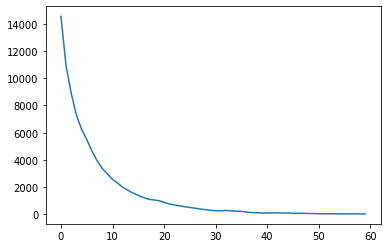

In [9]:
import matplotlib.pyplot as plt
plt.plot(lengths)